In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")  # Move to the project root

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import yaml
from collections import Counter, defaultdict
from pathlib import Path
import pandas as pd
import numpy as np

def load_data(debiased_samples_path: str, harm_assignments_path: str):
    """Load and preprocess data for analysis"""
    with open(debiased_samples_path, 'r') as f:
        data = json.load(f)
    with open(harm_assignments_path, 'r') as f:
        harm_assignments = yaml.safe_load(f)
    return data, harm_assignments

def analyze_dataset(data, harm_assignments):
    """Generate various plots analyzing the debiasing process"""
    
    # 1. Number of iterations per query
    plt.figure(figsize=(10, 6))
    iterations = [len(sample['lineage']) for sample in data]
    sns.histplot(iterations)
    plt.title('Distribution of Iterations per Query')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Count')
    plt.savefig('iterations_distribution.png')
    plt.close()

    # 2. Most common harm types detected
    harm_counts = defaultdict(int)
    for sample in data:
        for feedback_round in sample['feedback']:
            for feedback in feedback_round:
                feedback_json = json.loads(feedback)
                for harm_type, assessment in feedback_json['analysis'].items():
                    if assessment != "none":
                        harm_counts[harm_type] += 1
    
    plt.figure(figsize=(12, 6))
    harm_types = list(harm_counts.keys())
    counts = list(harm_counts.values())
    plt.bar(harm_types, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title('Frequency of Detected Harm Types')
    plt.xlabel('Harm Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('harm_types_frequency.png')
    plt.close()

    # 3. Text length changes
    original_lengths = [len(sample['original_query'].split()) for sample in data]
    final_lengths = [len(sample['debiased_response'].split()) for sample in data]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(original_lengths, final_lengths, alpha=0.5)
    plt.plot([0, max(original_lengths)], [0, max(original_lengths)], 'r--')  # diagonal line
    plt.title('Text Length: Original vs Debiased')
    plt.xlabel('Original Length (words)')
    plt.ylabel('Debiased Length (words)')
    plt.savefig('length_comparison.png')
    plt.close()

    # 4. Model agreement analysis
    model_agreement = []
    for sample in data:
        for feedback_round in sample['feedback']:
            round_issues = defaultdict(set)
            for i, feedback in enumerate(feedback_round):
                feedback_json = json.loads(feedback)
                for harm_type, assessment in feedback_json['analysis'].items():
                    if assessment != "none":
                        round_issues[harm_type].add(i)
            agreement_scores = [len(models)/len(feedback_round) for models in round_issues.values()]
            if agreement_scores:
                model_agreement.extend(agreement_scores)
    
    plt.figure(figsize=(8, 6))
    sns.histplot(model_agreement, bins=20)
    plt.title('Model Agreement on Harm Detection')
    plt.xlabel('Agreement Score (0-1)')
    plt.ylabel('Count')
    plt.savefig('model_agreement.png')
    plt.close()

    # 5. Convergence analysis
    def get_text_similarity(text1, text2):
        """Simple word overlap similarity"""
        words1 = set(text1.lower().split())
        words2 = set(text2.lower().split())
        return len(words1.intersection(words2)) / len(words1.union(words2))

    convergence_rates = []
    for sample in data:
        similarities = []
        for i in range(1, len(sample['lineage'])):
            sim = get_text_similarity(sample['lineage'][i-1], sample['lineage'][i])
            similarities.append(sim)
        if similarities:
            convergence_rates.append(similarities)
    
    plt.figure(figsize=(10, 6))
    for rate in convergence_rates:
        plt.plot(range(1, len(rate)+1), rate, alpha=0.1, color='blue')
    plt.plot(range(1, max(len(r) for r in convergence_rates)+1), 
             [np.mean([r[i] for r in convergence_rates if len(r)>i]) for i in range(max(len(r) for r in convergence_rates))],
             'r-', linewidth=2, label='Average')
    plt.title('Convergence Analysis')
    plt.xlabel('Iteration')
    plt.ylabel('Similarity to Previous Version')
    plt.legend()
    plt.savefig('convergence_analysis.png')
    plt.close()

In [4]:
debiased_samples = '../captions/centralized_dbiased_captions_cifar100_man_woman_baby_girl_boy.json'
harm_assignments = '/home/sklioui/multi-llm-debiasing-framework/harm_assignments.yaml'

In [33]:
!pip install biasana

  Preparing metadata (setup.py) ... one
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 69.5 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 95.1 MB/s eta 0:00:005 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.6 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26303 sha256=06dde593db62feb2a77750e34015f66a23802781a4cacb323d7b00236fcba24e
  Stored in directory: /home/sklioui/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing


In [34]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.7 MB/s eta 0:00:000:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
data, harm_assignments = load_data(debiased_samples, harm_assignments)
analyze_dataset(data, harm_assignments) 

In [8]:
# 1. Harm Type Frequency Distribution
harm_counts = defaultdict(int)
for example in data:
    for feedback_iteration in example['feedback']:
        for model_feedback in feedback_iteration:
            feedback = json.loads(model_feedback)
            for harm_type, assessment in feedback['analysis'].items():
                if assessment.lower() != 'none':
                    harm_counts[harm_type] += 1

harm_df = pd.DataFrame(list(harm_counts.items()), columns=['Harm Type', 'Count'])

plt.figure(figsize=(10, 6))
harm_df.sort_values('Count', ascending=False).plot.bar(x='Harm Type', y='Count')
plt.title('Harm Type Frequency Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('harm_frequency.png')
plt.close()

# 2. Model Contribution Radar Chart with Agreement
models = [m for m in harm_assignments if m != 'Qwen/Qwen2.5-14B-Instruct']
harm_categories = list(harm_assignments[models[0]]['harm_types']) if models else []

model_detections = {model: defaultdict(int) for model in models}
agreement_counts = defaultdict(int)

for example in data:
    for feedback_iteration in example['feedback']:
        for model_idx, model_feedback in enumerate(feedback_iteration):
            model = models[model_idx] if model_idx < len(models) else None
            if not model:
                continue
                
            feedback = json.loads(model_feedback)
            detected_harms = []
            
            for harm_type, assessment in feedback['analysis'].items():
                if assessment.lower() != 'none' and harm_type in get_harm_types(model):
                    model_detections[model][harm_type] += 1
                    detected_harms.append(harm_type)
            
            # Track agreement
            for harm_type in detected_harms:
                example_harm_detectors = defaultdict(int)
                for iter_fb in example['feedback']:
                    for m_idx, m_fb in enumerate(iter_fb):
                        m = models[m_idx] if m_idx < len(models) else None
                        if m and harm_type in json.loads(m_fb)['analysis']:
                            if json.loads(m_fb)['analysis'][harm_type].lower() != 'none':
                                example_harm_detectors[harm_type] += 1
                
                agreement_counts[harm_type] += example_harm_detectors[harm_type] / len(models)

# Prepare radar data
angles = np.linspace(0, 2*np.pi, len(harm_categories), endpoint=False).tolist()
angles += angles[:1]  # Close the polygon

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})

# Plot models
for model in models:
    values = [model_detections[model][harm] for harm in harm_categories]
    values += values[:1]  # Close the polygon
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=model.split('/')[-1])
    ax.fill(angles, values, alpha=0.1)

# Plot agreement
agreement = [agreement_counts[harm]/len(data) for harm in harm_categories]
agreement += agreement[:1]
ax.plot(angles, agreement, color='gold', linewidth=2, label='Agreement Level')

ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), harm_categories)
ax.set_title('Model Detection Patterns and Agreement Level')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.savefig('model_radar.png', bbox_inches='tight')
plt.close()

# 3. Bias Resolution Flow (Simplified version)
iteration_data = []
for ex_idx, example in enumerate(data):
    harms_per_iteration = defaultdict(set)
    
    for iter_idx, feedback_iteration in enumerate(example['feedback']):
        for model_feedback in feedback_iteration:
            feedback = json.loads(model_feedback)
            for harm_type, assessment in feedback['analysis'].items():
                if assessment.lower() != 'none':
                    harms_per_iteration[iter_idx].add(harm_type)
    
    # Create resolution flow
    for i in range(len(harms_per_iteration)):
        if i == 0:
            continue
        resolved = harms_per_iteration[i-1] - harms_per_iteration[i]
        if resolved:
            iteration_data.extend([(h, f'Iter {i}') for h in resolved])

resolution_df = pd.DataFrame(iteration_data, columns=['Harm Type', 'Resolution Iteration'])

if not resolution_df.empty:
    plt.figure(figsize=(10, 6))
    resolution_counts = resolution_df.groupby(['Harm Type', 'Resolution Iteration']).size().unstack()
    resolution_counts.plot(kind='bar', stacked=True)
    plt.title('Bias Resolution Flow')
    plt.xlabel('Harm Type')
    plt.ylabel('Resolutions Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Resolved in Iteration')
    plt.tight_layout()
    plt.savefig('resolution_flow.png')
    plt.close()
else:
    print("Insufficient data for resolution flow chart")

# 5. Iteration Depth Histogram
iteration_counts = [len(example['lineage']) for example in data]

plt.figure(figsize=(8, 5))
plt.hist(iteration_counts, 
         bins=np.arange(min(iteration_counts)-0.5, max(iteration_counts)+1.5, 1),
         edgecolor='black')
plt.title('Iteration Depth Distribution')
plt.xlabel('Number of Iterations')
plt.ylabel('Count')
plt.xticks(range(min(iteration_counts), max(iteration_counts)+1))
plt.savefig('iteration_depth.png')
plt.close()

NameError: name 'get_harm_types' is not defined

<Figure size 1000x600 with 0 Axes>

In [13]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Function to retrieve assigned harms for each model
def get_harm_types(model):
    return harm_assignments.get(model, {}).get("harm_types", [])

# 1. Harm Type Frequency Distribution
harm_counts = defaultdict(int)
for example in data:
    for feedback_iteration in example["feedback"]:
        for model_feedback in feedback_iteration:
            feedback = json.loads(model_feedback)
            for harm_type, assessment in feedback["analysis"].items():
                if assessment.lower() != "none":
                    harm_counts[harm_type] += 1

harm_df = pd.DataFrame(list(harm_counts.items()), columns=["Harm Type", "Count"])
harm_df.sort_values("Count", ascending=True, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=harm_df, y="Harm Type", x="Count", palette="Blues_r", log=True)
plt.title("Harm Type Frequency Distribution")
plt.xlabel("Count (Log Scale)")
plt.ylabel("Harm Type")
plt.tight_layout()
plt.savefig("harm_frequency.png")
plt.close()

# 2. Model Contribution Radar Chart with Agreement
models = [m for m in harm_assignments if m != "Qwen/Qwen2.5-14B-Instruct"]
harm_categories = list(harm_assignments[models[0]]["harm_types"]) if models else []

model_detections = {model: defaultdict(int) for model in models}
agreement_counts = defaultdict(int)

for example in data:
    for feedback_iteration in example["feedback"]:
        for model_idx, model_feedback in enumerate(feedback_iteration):
            model = models[model_idx] if model_idx < len(models) else None
            if not model:
                continue

            feedback = json.loads(model_feedback)
            detected_harms = []

            for harm_type, assessment in feedback["analysis"].items():
                if assessment.lower() != "none" and harm_type in get_harm_types(model):
                    model_detections[model][harm_type] += 1
                    detected_harms.append(harm_type)

            # Track agreement
            for harm_type in detected_harms:
                example_harm_detectors = defaultdict(int)
                for iter_fb in example["feedback"]:
                    for m_idx, m_fb in enumerate(iter_fb):
                        m = models[m_idx] if m_idx < len(models) else None
                        if m and harm_type in json.loads(m_fb)["analysis"]:
                            if json.loads(m_fb)["analysis"][harm_type].lower() != "none":
                                example_harm_detectors[harm_type] += 1

                agreement_counts[harm_type] += example_harm_detectors[harm_type] / len(models)

# Rescale agreement for better visibility
max_detection = max(max(v.values(), default=0) for v in model_detections.values()) or 1
agreement_scaled = {harm: (agreement_counts[harm] / len(data)) * max_detection for harm in harm_categories}

# Prepare radar chart data
angles = np.linspace(0, 2 * np.pi, len(harm_categories), endpoint=False).tolist()
angles += angles[:1]  # Close the polygon

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"polar": True})

# Plot models
for model in models:
    values = [model_detections[model][harm] for harm in harm_categories]
    values += values[:1]  # Close the polygon
    ax.plot(angles, values, linewidth=1, linestyle="solid", label=model.split("/")[-1])
    ax.fill(angles, values, alpha=0.1)

# Plot agreement
agreement_values = [agreement_scaled[harm] for harm in harm_categories]
agreement_values += agreement_values[:1]
ax.plot(angles, agreement_values, color="gold", linewidth=2, label="Agreement Level")

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), harm_categories)
ax.set_title("Model Detection Patterns and Agreement Level")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.savefig("model_radar.png", bbox_inches="tight")
plt.close()

# 3. Bias Resolution Flow (Heatmap)
iteration_data = defaultdict(lambda: defaultdict(int))

for ex_idx, example in enumerate(data):
    harms_per_iteration = defaultdict(set)

    for iter_idx, feedback_iteration in enumerate(example["feedback"]):
        for model_feedback in feedback_iteration:
            feedback = json.loads(model_feedback)
            for harm_type, assessment in feedback["analysis"].items():
                if assessment.lower() != "none":
                    harms_per_iteration[iter_idx].add(harm_type)

    # Track harm resolutions
    for i in range(1, len(harms_per_iteration)):
        resolved = harms_per_iteration[i - 1] - harms_per_iteration[i]
        for harm in resolved:
            iteration_data[harm][f"Iter {i}"] += 1

# Convert to DataFrame
resolution_df = pd.DataFrame(iteration_data).T.fillna(0)

if not resolution_df.empty:
    plt.figure(figsize=(10, 6))
    sns.heatmap(resolution_df, annot=True, cmap="Greens", fmt=".0f", linewidths=0.5)
    plt.title("Bias Resolution Flow")
    plt.xlabel("Resolved in Iteration")
    plt.ylabel("Harm Type")
    plt.tight_layout()
    plt.savefig("resolution_flow.png")
    plt.close()
else:
    print("Insufficient data for resolution flow chart")

# 4. Iteration Depth Histogram
iteration_counts = [len(example["lineage"]) for example in data]

plt.figure(figsize=(8, 5))
sns.histplot(iteration_counts, bins=range(min(iteration_counts), max(iteration_counts) + 2), edgecolor="black", kde=True)
plt.axvline(np.mean(iteration_counts), color="red", linestyle="dashed", linewidth=1, label=f"Mean: {np.mean(iteration_counts):.2f}")
plt.title("Iteration Depth Distribution")
plt.xlabel("Number of Iterations")
plt.ylabel("Count")
plt.xticks(range(min(iteration_counts), max(iteration_counts) + 1))
plt.legend()
plt.savefig("iteration_depth.png")
plt.close()


/tmp/ipykernel_177656/1772576238.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=harm_df, y="Harm Type", x="Count", palette="Blues_r", log=True)
/home/sklioui/miniconda3/envs/luma_unbias/lib/python3.10/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)
/home/sklioui/miniconda3/envs/luma_unbias/lib/python3.10/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)
/home/sklioui/miniconda3/envs/luma_unbias/lib/python3.10/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)
/home/sklioui/miniconda3/envs/luma_unbias/lib/python3.10/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.pow

In [7]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Helper function to get harm types for models
def get_harm_types(model):
    return harm_assignments.get(model, {}).get("harm_types", [])

# 1. Harm Type Frequency Distribution
harm_counts = defaultdict(int)
for example in data:
    for feedback_iteration in example["feedback"]:
        for model_feedback in feedback_iteration:
            feedback = json.loads(model_feedback)
            for harm_type, assessment in feedback["analysis"].items():
                if assessment.lower() != "none":
                    harm_counts[harm_type] += 1

harm_df = pd.DataFrame(list(harm_counts.items()), columns=["Harm Type", "Count"])
harm_df.sort_values("Count", ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=harm_df, x="Count", y="Harm Type", palette="Reds_r")
plt.title("Harm Type Frequency Distribution")
plt.xlabel("Count")
plt.ylabel("Harm Type")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("harm_frequency.png")
plt.close()

# 2. Model Contribution Radar Chart with Agreement
models = [m for m in harm_assignments if m != "Qwen/Qwen2.5-14B-Instruct"]
harm_categories = list(harm_assignments[models[0]]["harm_types"]) if models else []

model_detections = {model: defaultdict(int) for model in models}
agreement_counts = defaultdict(int)

for example in data:
    for feedback_iteration in example["feedback"]:
        for model_idx, model_feedback in enumerate(feedback_iteration):
            model = models[model_idx] if model_idx < len(models) else None
            if not model:
                continue

            feedback = json.loads(model_feedback)
            detected_harms = []

            for harm_type, assessment in feedback["analysis"].items():
                if assessment.lower() != "none" and harm_type in get_harm_types(model):
                    model_detections[model][harm_type] += 1
                    detected_harms.append(harm_type)

            # Track agreement
            for harm_type in detected_harms:
                example_harm_detectors = defaultdict(int)
                for iter_fb in example["feedback"]:
                    for m_idx, m_fb in enumerate(iter_fb):
                        m = models[m_idx] if m_idx < len(models) else None
                        if m and harm_type in json.loads(m_fb)["analysis"]:
                            if json.loads(m_fb)["analysis"][harm_type].lower() != "none":
                                example_harm_detectors[harm_type] += 1

                agreement_counts[harm_type] += example_harm_detectors[harm_type] / len(models)

# Normalize agreement scale
max_detection = max(max(v.values(), default=0) for v in model_detections.values()) or 1
agreement_scaled = {harm: (agreement_counts[harm] / len(data)) * max_detection for harm in harm_categories}

# Prepare radar chart data
angles = np.linspace(0, 2 * np.pi, len(harm_categories), endpoint=False).tolist()
angles += angles[:1]  # Close the polygon

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"polar": True})

# Plot models
for model in models:
    values = [model_detections[model][harm] for harm in harm_categories]
    values += values[:1]  # Close the polygon
    ax.plot(angles, values, linewidth=1, linestyle="solid", label=model.split("/")[-1])
    ax.fill(angles, values, alpha=0.1)

# Plot agreement
agreement_values = [agreement_scaled[harm] for harm in harm_categories]
agreement_values += agreement_values[:1]
ax.plot(angles, agreement_values, color="gold", linewidth=2, label="Agreement Level")

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), harm_categories)
ax.set_ylim(0, max_detection)  # Adjust scale to match highest detection count
ax.set_title("Model Detection Patterns and Agreement Level")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.savefig("model_radar.png", bbox_inches="tight")
plt.close()

# 3. Bias Resolution Flow (Step Plot)
iteration_data = defaultdict(lambda: defaultdict(int))

for ex_idx, example in enumerate(data):
    harms_per_iteration = defaultdict(set)

    for iter_idx, feedback_iteration in enumerate(example["feedback"]):
        for model_feedback in feedback_iteration:
            feedback = json.loads(model_feedback)
            for harm_type, assessment in feedback["analysis"].items():
                if assessment.lower() != "none":
                    harms_per_iteration[iter_idx].add(harm_type)

    # Track harm resolutions
    for i in range(1, len(harms_per_iteration)):
        resolved = harms_per_iteration[i - 1] - harms_per_iteration[i]
        for harm in resolved:
            iteration_data[harm][f"Iter {i}"] += 1

# Convert to DataFrame
resolution_df = pd.DataFrame(iteration_data).T.fillna(0)

if not resolution_df.empty:
    plt.figure(figsize=(10, 6))
    for harm in resolution_df.index:
        plt.step(resolution_df.columns, resolution_df.loc[harm], where="mid", label=harm)

    plt.title("Bias Resolution Flow Over Iterations")
    plt.xlabel("Iteration Step")
    plt.ylabel("Resolved Harms Count")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("resolution_flow.png")
    plt.close()
else:
    print("Insufficient data for resolution flow chart")

# 4. Iteration Depth Histogram
iteration_counts = [len(example["lineage"]) for example in data]

plt.figure(figsize=(8, 5))
sns.histplot(iteration_counts, bins=range(min(iteration_counts), max(iteration_counts) + 2), edgecolor="black", kde=True)
plt.axvline(np.mean(iteration_counts), color="red", linestyle="dashed", linewidth=1, label=f"Mean: {np.mean(iteration_counts):.2f}")
plt.title("Iteration Depth Distribution")
plt.xlabel("Number of Iterations")
plt.ylabel("Count")
plt.xticks(range(min(iteration_counts), max(iteration_counts) + 1))
plt.legend()
plt.savefig("iteration_depth.png")
plt.close()


/tmp/ipykernel_115125/473165359.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=harm_df, x="Count", y="Harm Type", palette="Reds_r")


In [10]:
harm_assignments.keys()[1:]

TypeError: 'dict_keys' object is not subscriptable

In [16]:
# Extract agreement counts per model per harm type
agreement_counts = defaultdict(lambda: defaultdict(float))

models = list(harm_assignments.keys())[1:]  # Exclude leader model (first entry)

for example in data:
    for feedback_iteration in example["feedback"]:
        for model_idx, model_feedback in enumerate(feedback_iteration):
            if model_idx >= len(models):  # Avoid index errors
                continue
            model = models[model_idx]  # Correct model selection

            feedback = json.loads(model_feedback)
            detected_harms = []

            for harm_type, assessment in feedback["analysis"].items():
                if assessment.lower() != "none":
                    detected_harms.append(harm_type)

            # Agreement computation
            for harm_type in detected_harms:
                agreeing_models = sum(
                    1 for iter_fb in example["feedback"]
                    for m_idx, m_fb in enumerate(iter_fb)
                    if m_idx < len(models) and harm_type in json.loads(m_fb)["analysis"]
                    and json.loads(m_fb)["analysis"][harm_type].lower() != "none"
                )
                agreement_counts[model][harm_type] += agreeing_models / len(models)

# Convert to DataFrame
agreement_df = pd.DataFrame(agreement_counts).fillna(0)

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Left: Harm Frequency by Model (Log Scale) ---
harm_counts_by_model = defaultdict(lambda: defaultdict(int))
for example in data:
    for feedback_iteration in example["feedback"]:
        for model_idx, model_feedback in enumerate(feedback_iteration):
            if model_idx >= len(models):
                continue
            model = models[model_idx]
            feedback = json.loads(model_feedback)
            for harm_type, assessment in feedback["analysis"].items():
                if assessment.lower() != "none":
                    harm_counts_by_model[model][harm_type] += 1

harm_counts_df = pd.DataFrame(harm_counts_by_model).fillna(0) + 1  # Avoid log(0)
harm_counts_long = harm_counts_df.reset_index().melt(id_vars="index", var_name="Model", value_name="Count")
harm_counts_long.rename(columns={"index": "Harm Type"}, inplace=True)

sns.barplot(data=harm_counts_long, x="Harm Type", y="Count", hue="Model", palette="tab10", ax=axes[0])
axes[0].set_yscale("log")  # Log scale
axes[0].set_title("Harm Type Frequency by Model (Log Scale)")
axes[0].set_xlabel("Harm Type")
axes[0].set_ylabel("Log Count")
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(axis="y", linestyle="--", alpha=0.5)
axes[0].legend(title="Model", bbox_to_anchor=(1, 1), loc="upper left", fontsize=10)

# --- Right: Agreement Heatmap ---
plt.subplot(1, 2, 2)
plt.title("Agreement Level per Model by Harm Type")
sns.heatmap(agreement_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, ax=axes[1])
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Harm Type")

plt.tight_layout()
plt.savefig("harm_frequency_agreement_heatmap.png")
plt.close()

In [18]:
# --- PLOT 2: Inter-model Agreement Heatmap ---
# Improved implementation of inter-model agreement
agreement_matrix = defaultdict(lambda: defaultdict(float))
detection_counts = defaultdict(lambda: defaultdict(int))

for example in data:
    # Process each example
    for harm_type in harm_assignments[models[0]]["harm_types"]:  # Use first model's harm types
        # For each harm iteration
        for feedback_iteration in example["feedback"]:
            # Count how many models detected this harm type in this iteration
            detected_by = set()
            
            for model_idx, model_feedback in enumerate(feedback_iteration):
                if model_idx >= len(models):
                    continue
                    
                model = models[model_idx]
                try:
                    feedback = json.loads(model_feedback)
                    assessment = feedback["analysis"].get(harm_type, "none")
                    
                    if assessment.lower() != "none":
                        detected_by.add(model)
                        detection_counts[harm_type][model] += 1
                except:
                    continue
            
            # Calculate agreement (if at least one model detected the harm)
            if detected_by:
                for model in detected_by:
                    # Calculate agreement ratio for this model (excluding itself)
                    other_models = len(detected_by.difference({model}))
                    total_other_models = len(models) - 1
                    
                    if total_other_models > 0:  # Avoid division by zero
                        agreement_matrix[harm_type][model] += other_models / total_other_models

# Normalize agreement by detection counts
for harm_type in agreement_matrix:
    for model in agreement_matrix[harm_type]:
        if detection_counts[harm_type][model] > 0:
            agreement_matrix[harm_type][model] /= detection_counts[harm_type][model]

# Create DataFrame for agreement matrix
agreement_df = pd.DataFrame(agreement_matrix).fillna(0)

# Create the second plot
plt.figure(figsize=(12, 8))
sns.heatmap(agreement_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Average Agreement Level: When a Model Detects Harm, How Often Other Models Agree")
plt.xlabel("Harm Type")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("inter_model_agreement_heatmap.png")
plt.close()

In [ ]:
models = list(harm_assignments.keys())[1:]  # Exclude leader model (first entry)

# --- PLOT 1: Harm Frequency by Model (Log Scale) ---
harm_counts_by_model = defaultdict(lambda: defaultdict(int))

for example in data:
    for feedback_iteration in example["feedback"]:
        for model_idx, model_feedback in enumerate(feedback_iteration):
            if model_idx >= len(models):
                continue
            model = models[model_idx]
            feedback = json.loads(model_feedback)
            for harm_type, assessment in feedback["analysis"].items():
                if assessment.lower() != "none":
                    harm_counts_by_model[model][harm_type] += 1

# Create DataFrame for harm counts
harm_counts_df = pd.DataFrame(harm_counts_by_model).fillna(0)
# Add 1 to avoid log(0) issues
harm_counts_df = harm_counts_df + 1

# Convert to long format for seaborn
harm_counts_long = harm_counts_df.reset_index().melt(
    id_vars="index", 
    var_name="Model", 
    value_name="Count"
)
harm_counts_long.rename(columns={"index": "Harm Type"}, inplace=True)

# Create the first plot
plt.figure(figsize=(12, 8))
sns.barplot(data=harm_counts_long, x="Harm Type", y="Count", hue="Model", palette="tab10")
plt.yscale("log")  # Log scale
plt.title("Harm Type Frequency by Model (Log Scale, Count+1)")
plt.xlabel("Harm Type")
plt.ylabel("Log Count (+1)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="Model", bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.savefig("harm_frequency_by_model.png")
plt.close()


# --- PLOT 2: Inter-model Agreement Heatmap ---
# Improved implementation of inter-model agreement
agreement_matrix = defaultdict(lambda: defaultdict(float))
detection_counts = defaultdict(lambda: defaultdict(int))

for example in data:
    # Process each example
    for harm_type in harm_assignments[models[0]]["harm_types"]:  # Use first model's harm types
        # For each harm iteration
        for feedback_iteration in example["feedback"]:
            # Count how many models detected this harm type in this iteration
            detected_by = set()
            
            for model_idx, model_feedback in enumerate(feedback_iteration):
                if model_idx >= len(models):
                    continue
                    
                model = models[model_idx]
                try:
                    feedback = json.loads(model_feedback)
                    assessment = feedback["analysis"].get(harm_type, "none")
                    
                    if assessment.lower() != "none":
                        detected_by.add(model)
                        detection_counts[harm_type][model] += 1
                except:
                    continue
            
            # Calculate agreement (if at least one model detected the harm)
            if detected_by:
                for model in detected_by:
                    # Calculate agreement ratio for this model (excluding itself)
                    other_models = len(detected_by.difference({model}))
                    total_other_models = len(models) - 1
                    
                    if total_other_models > 0:  # Avoid division by zero
                        agreement_matrix[harm_type][model] += other_models / total_other_models

# Normalize agreement by detection counts
for harm_type in agreement_matrix:
    for model in agreement_matrix[harm_type]:
        if detection_counts[harm_type][model] > 0:
            agreement_matrix[harm_type][model] /= detection_counts[harm_type][model]

# Create DataFrame for agreement matrix
agreement_df = pd.DataFrame(agreement_matrix).fillna(0)

# Create the second plot
plt.figure(figsize=(12, 8))
sns.heatmap(agreement_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Average Agreement Level: When a Model Detects Harm, How Often Other Models Agree")
plt.xlabel("Harm Type")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("inter_model_agreement_heatmap.png")
plt.close()

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from collections import defaultdict

# Assuming data and harm_assignments are already defined
models = list(harm_assignments.keys())[1:]  # Exclude leader model (first entry)

# --- First Plot Data: Harm Frequency by Model (Log Scale) ---
harm_counts_by_model = defaultdict(lambda: defaultdict(int))

for example in data:
    for feedback_iteration in example["feedback"]:
        for model_idx, model_feedback in enumerate(feedback_iteration):
            if model_idx >= len(models):
                continue
            model = models[model_idx]
            feedback = json.loads(model_feedback)
            for harm_type, assessment in feedback["analysis"].items():
                if assessment.lower() != "none":
                    harm_counts_by_model[model][harm_type] += 1

# Create DataFrame for harm counts
harm_counts_df = pd.DataFrame(harm_counts_by_model).fillna(0)
# Add 1 to avoid log(0) issues
harm_counts_df = harm_counts_df + 1

# Convert to long format for seaborn
harm_counts_long = harm_counts_df.reset_index().melt(
    id_vars="index", 
    var_name="Model", 
    value_name="Count"
)
harm_counts_long.rename(columns={"index": "Harm Type"}, inplace=True)

# --- Second Plot Data: Inter-model Agreement ---
agreement_matrix = defaultdict(lambda: defaultdict(float))
detection_counts = defaultdict(lambda: defaultdict(int))

for example in data:
    for harm_type in harm_assignments[models[0]]["harm_types"]:
        for feedback_iteration in example["feedback"]:
            detected_by = set()
            
            for model_idx, model_feedback in enumerate(feedback_iteration):
                if model_idx >= len(models):
                    continue
                    
                model = models[model_idx]
                try:
                    feedback = json.loads(model_feedback)
                    assessment = feedback["analysis"].get(harm_type, "none")
                    
                    if assessment.lower() != "none":
                        detected_by.add(model)
                        detection_counts[harm_type][model] += 1
                except:
                    continue
            
            if detected_by:
                for model in detected_by:
                    other_models = len(detected_by.difference({model}))
                    total_other_models = len(models) - 1
                    
                    if total_other_models > 0:
                        agreement_matrix[harm_type][model] += other_models / total_other_models

# Normalize agreement by detection counts
for harm_type in agreement_matrix:
    for model in agreement_matrix[harm_type]:
        if detection_counts[harm_type][model] > 0:
            agreement_matrix[harm_type][model] /= detection_counts[harm_type][model]

# Create DataFrame for agreement matrix
agreement_df = pd.DataFrame(agreement_matrix).fillna(0)

# --- Create Combined Plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)

# Enhance figure appearance
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Left plot - Harm Frequency (simplified)
# Group by harm type and sum across models to reduce visual clutter
harm_type_totals = harm_counts_long.groupby("Harm Type")["Count"].sum().reset_index()
sns.barplot(data=harm_type_totals, x="Harm Type", y="Count", ax=ax1, color='steelblue')
ax1.set_yscale("log")
ax1.set_title("Harm Type Frequency (Log Scale)")
ax1.set_xlabel("")
ax1.set_ylabel("Log Count (+1)")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
ax1.grid(axis="y", linestyle="--", alpha=0.3)

# Right plot - Agreement Heatmap (cleaner version)
sns.heatmap(agreement_df, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, ax=ax2, cbar_kws={"shrink": 0.8})
ax2.set_title("Inter-Model Agreement Level")
ax2.set_xlabel("")
ax2.set_ylabel("")

# Add overall title and adjust layout
fig.suptitle("Harm Detection Analysis Across Models", fontsize=14, y=0.98)
plt.savefig("combined_harm_analysis.png", dpi=300, bbox_inches="tight")
plt.close()

/tmp/ipykernel_115125/1349566697.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
from collections import defaultdict

# Assuming data and harm_assignments are already defined
models = list(harm_assignments.keys())[1:]  # Exclude leader model (first entry)

# --- First Plot Data: Harm Frequency by Model (Log Scale) ---
harm_counts_by_model = defaultdict(lambda: defaultdict(int))

for example in data:
    for feedback_iteration in example["feedback"]:
        for model_idx, model_feedback in enumerate(feedback_iteration):
            if model_idx >= len(models):
                continue
            model = models[model_idx]
            feedback = json.loads(model_feedback)
            for harm_type, assessment in feedback["analysis"].items():
                if assessment.lower() != "none":
                    harm_counts_by_model[model][harm_type] += 1

# Create DataFrame for harm counts
harm_counts_df = pd.DataFrame(harm_counts_by_model).fillna(0)
# Add 1 to avoid log(0) issues
harm_counts_df = harm_counts_df + 1

# Convert to long format for seaborn
harm_counts_long = harm_counts_df.reset_index().melt(
    id_vars="index", 
    var_name="Model", 
    value_name="Count"
)
harm_counts_long.rename(columns={"index": "Harm Type"}, inplace=True)

# --- Second Plot Data: Inter-model Agreement ---
agreement_matrix = defaultdict(lambda: defaultdict(float))
detection_counts = defaultdict(lambda: defaultdict(int))

for example in data:
    for harm_type in harm_assignments[models[0]]["harm_types"]:
        for feedback_iteration in example["feedback"]:
            detected_by = set()
            
            for model_idx, model_feedback in enumerate(feedback_iteration):
                if model_idx >= len(models):
                    continue
                    
                model = models[model_idx]
                try:
                    feedback = json.loads(model_feedback)
                    assessment = feedback["analysis"].get(harm_type, "none")
                    
                    if assessment.lower() != "none":
                        detected_by.add(model)
                        detection_counts[harm_type][model] += 1
                except:
                    continue
            
            if detected_by:
                for model in detected_by:
                    other_models = len(detected_by.difference({model}))
                    total_other_models = len(models) - 1
                    
                    if total_other_models > 0:
                        agreement_matrix[harm_type][model] += other_models / total_other_models

# Normalize agreement by detection counts
for harm_type in agreement_matrix:
    for model in agreement_matrix[harm_type]:
        if detection_counts[harm_type][model] > 0:
            agreement_matrix[harm_type][model] /= detection_counts[harm_type][model]

# Create DataFrame for agreement matrix
agreement_df = pd.DataFrame(agreement_matrix).fillna(0)

# --- Create Combined Plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)

# Enhance figure appearance
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Get all unique harm types
all_harm_types = harm_counts_long['Harm Type'].unique().tolist()
selected_harm_types = ['ERASURE', 'EXCLUSIONARY', 'MISREPRESENTATION', 'STEREOTYPING']
other_harm_types = [ht for ht in all_harm_types if ht not in selected_harm_types]

# Create a pivot table for the data
pivot_data = pd.pivot_table(
    harm_counts_long, 
    values='Count', 
    index='Harm Type', 
    columns='Model',
    fill_value=1  # Use 1 since we're adding 1 to avoid log(0)
)

# Plot stacked bars for selected harm types and regular bars for others
width = 0.8
x_positions = np.arange(len(all_harm_types))
bar_bottom = np.ones(len(other_harm_types))  # Starting at 1 for log scale

# First, plot the regular bars for other harm types
other_totals = pivot_data.loc[other_harm_types].sum(axis=1)
other_indices = [all_harm_types.index(ht) for ht in other_harm_types]
ax1.bar(
    [x_positions[i] for i in other_indices], 
    other_totals, 
    width=width, 
    color='steelblue', 
    label='All Models'
)

# Then plot stacked bars for selected harm types
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
selected_indices = [all_harm_types.index(ht) for ht in selected_harm_types]

for i, model in enumerate(models):
    # Only plot for selected harm types
    heights = [pivot_data.loc[ht, model] if ht in pivot_data.index and model in pivot_data.columns else 1 
               for ht in selected_harm_types]
    positions = [x_positions[idx] for idx in selected_indices]
    
    if i == 0:  # First model
        ax1.bar(positions, heights, width=width, color=colors[i], label=model)
        bottoms = heights
    else:  # Stack subsequent models
        ax1.bar(positions, heights, width=width, bottom=bottoms, color=colors[i], label=model)
        bottoms = [bottoms[j] + heights[j] for j in range(len(heights))]

# Set logarithmic scale and other formatting
ax1.set_yscale('log')
ax1.set_title("Harm Type Frequency (Log Scale)")
ax1.set_xlabel("")
ax1.set_ylabel("Log Count (+1)")
ax1.set_xticks(x_positions)
ax1.set_xticklabels(all_harm_types, rotation=45, ha="right")
for i in selected_indices:
    ax1.get_xticklabels()[i].set_fontweight('bold')
ax1.grid(axis="y", linestyle="--", alpha=0.3)
ax1.legend(title="Model", bbox_to_anchor=(1.01, 1), loc="upper left")

# Right plot - Agreement Heatmap
sns.heatmap(agreement_df, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, ax=ax2, cbar_kws={"shrink": 0.8})
ax2.set_title("Inter-Model Agreement Level")
ax2.set_xlabel("")
ax2.set_ylabel("")

# Highlight the selected harm types on the heatmap
for j, harm_type in enumerate(selected_harm_types):
    if harm_type in agreement_df.columns:
        # Find the column index
        col_idx = list(agreement_df.columns).index(harm_type)
        # Add a thicker border
        ax2.axvline(x=col_idx, color='black', linewidth=2, alpha=0.5)
        ax2.axvline(x=col_idx+1, color='black', linewidth=2, alpha=0.5)

# Add overall title
fig.suptitle("Harm Detection Analysis Across Models (Stacked Detail for ERASURE, EXCLUSIONARY, MISREPRESENTATION, STEREOTYPING)", 
             fontsize=14, y=0.98)
plt.savefig("combined_harm_analysis_with_stacked.png", dpi=300, bbox_inches="tight")
plt.close()

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
from collections import defaultdict

# Assuming data and harm_assignments are already defined
models = list(harm_assignments.keys())[1:]  # Exclude leader model (first entry)

# --- First Plot Data: Harm Frequency by Model (Log Scale) ---
harm_counts_by_model = defaultdict(lambda: defaultdict(int))

for example in data:
    for feedback_iteration in example["feedback"]:
        for model_idx, model_feedback in enumerate(feedback_iteration):
            if model_idx >= len(models):
                continue
            model = models[model_idx]
            feedback = json.loads(model_feedback)
            for harm_type, assessment in feedback["analysis"].items():
                if assessment.lower() != "none":
                    harm_counts_by_model[model][harm_type] += 1

# Create DataFrame for harm counts
harm_counts_df = pd.DataFrame(harm_counts_by_model).fillna(0)
# Add 1 to avoid log(0) issues
harm_counts_df = harm_counts_df + 1

# Convert to long format for seaborn
harm_counts_long = harm_counts_df.reset_index().melt(
    id_vars="index", 
    var_name="Model", 
    value_name="Count"
)
harm_counts_long.rename(columns={"index": "Harm Type"}, inplace=True)

# --- Second Plot Data: Inter-model Agreement ---
agreement_matrix = defaultdict(lambda: defaultdict(float))
detection_counts = defaultdict(lambda: defaultdict(int))

for example in data:
    for harm_type in harm_assignments[models[0]]["harm_types"]:
        for feedback_iteration in example["feedback"]:
            detected_by = set()
            
            for model_idx, model_feedback in enumerate(feedback_iteration):
                if model_idx >= len(models):
                    continue
                    
                model = models[model_idx]
                try:
                    feedback = json.loads(model_feedback)
                    assessment = feedback["analysis"].get(harm_type, "none")
                    
                    if assessment.lower() != "none":
                        detected_by.add(model)
                        detection_counts[harm_type][model] += 1
                except:
                    continue
            
            if detected_by:
                for model in detected_by:
                    other_models = len(detected_by.difference({model}))
                    total_other_models = len(models) - 1
                    
                    if total_other_models > 0:
                        agreement_matrix[harm_type][model] += other_models / total_other_models

# Normalize agreement by detection counts
for harm_type in agreement_matrix:
    for model in agreement_matrix[harm_type]:
        if detection_counts[harm_type][model] > 0:
            agreement_matrix[harm_type][model] /= detection_counts[harm_type][model]

# Create DataFrame for agreement matrix
agreement_df = pd.DataFrame(agreement_matrix).fillna(0)

# --- Create Combined Plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)

# Enhance figure appearance
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'axes.labelsize': 14,  # Increased from 11
    'axes.titlesize': 16,  # Increased from 12
    'xtick.labelsize': 12,  # Increased from 10
    'ytick.labelsize': 12,  # Increased from 10
    'legend.fontsize': 11,  # Increased from default
    'legend.title_fontsize': 12  # Increased from default
})

# Get all unique harm types
all_harm_types = harm_counts_long['Harm Type'].unique().tolist()
selected_harm_types = ['ERASURE', 'EXCLUSIONARY', 'MISREPRESENTATION', 'STEREOTYPING']
other_harm_types = [ht for ht in all_harm_types if ht not in selected_harm_types]

# Create a pivot table for the data
pivot_data = pd.pivot_table(
    harm_counts_long, 
    values='Count', 
    index='Harm Type', 
    columns='Model',
    fill_value=1  # Use 1 since we're adding 1 to avoid log(0)
)

# Precompute sum of original counts for selected harm types
sum_original_per_ht = {}
for ht in selected_harm_types:
    sum_original = pivot_data.loc[ht, models].sum() - len(models)
    sum_original_per_ht[ht] = sum_original if sum_original > 0 else 0

# Plot stacked bars for selected harm types and regular bars for others
width = 0.8
x_positions = np.arange(len(all_harm_types))

# Use a harmonious color palette
colors = sns.color_palette("husl", len(models))

# First, plot the regular bars for other harm types
other_totals = pivot_data.loc[other_harm_types].sum(axis=1)
other_indices = [all_harm_types.index(ht) for ht in other_harm_types]
ax1.bar(
    [x_positions[i] for i in other_indices], 
    other_totals, 
    width=width, 
    color='silver',  # Neutral color for non-focused categories
    label='All Models'
)

# Plot stacked bars for selected harm types with percentages
current_bottoms = np.zeros(len(selected_harm_types))
for i, model in enumerate(models):
    heights = [pivot_data.loc[ht, model] if ht in pivot_data.index and model in pivot_data.columns else 1 
               for ht in selected_harm_types]
    positions = [x_positions[all_harm_types.index(ht)] for ht in selected_harm_types]
    
    ax1.bar(
        positions, 
        heights, 
        bottom=current_bottoms, 
        width=width, 
        color=colors[i], 
        label=model
    )

    # Add percentage labels
    for j, ht in enumerate(selected_harm_types):
        x = positions[j]
        y_pos = current_bottoms[j] + heights[j] / 2
        
        # Calculate percentage based on original counts
        original_count = heights[j] - 1
        sum_original = sum_original_per_ht[ht]
        
        if sum_original > 0:
            percentage = (original_count / sum_original) * 100
        else:
            percentage = 0

        # Determine text color based on luminance
        r, g, b = colors[i][0], colors[i][1], colors[i][2]
        luminance = 0.299 * r + 0.587 * g + 0.114 * b
        text_color = 'white' if luminance < 0.5 else 'black'

        # Format text
        label = f"{percentage:.1f}%" if percentage != 0 else "0%"
        ax1.text(
            x, y_pos, 
            label, 
            ha='center', va='center',
            color=text_color,
            fontsize=10,
            fontweight='bold' if text_color == 'white' else 'normal'
        )

    current_bottoms += heights

# Set logarithmic scale and other formatting
ax1.set_yscale('log')
ax1.set_title("Harm Type Frequency (Log Scale)")
ax1.set_xlabel("")
ax1.set_ylabel("Log Count (+1)")
ax1.set_xticks(x_positions)
ax1.set_xticklabels(all_harm_types, rotation=45, ha="right")
for i in [all_harm_types.index(ht) for ht in selected_harm_types]:
    ax1.get_xticklabels()[i].set_fontweight('bold')
ax1.grid(axis="y", linestyle="--", alpha=0.3)
ax1.legend(title="Model", loc="upper right")

selected_agreement_df = agreement_df[selected_harm_types]

# Right plot - Agreement Heatmap
sns.heatmap(
    selected_agreement_df, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    linewidths=0.5, 
    ax=ax2, 
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 12}  # Increased annotation font size
)

ax2.set_title("Inter-Model Agreement Level", fontsize=16)  # Increased from 12
ax2.set_xlabel("", fontsize=14)  # Increased from 11
ax2.set_ylabel("", fontsize=14)  # Increased from 11
ax2.tick_params(labelsize=12)  # Increased tick label size

ax2.set_title("Inter-Model Agreement Level")
ax2.set_xlabel("")
ax2.set_ylabel("")

plt.savefig("combined_harm_analysis_with_stacked.png", dpi=300, bbox_inches="tight")
plt.close()

Processing Examples:   0%|          | 0/3000 [00:00<?, ?it/s]

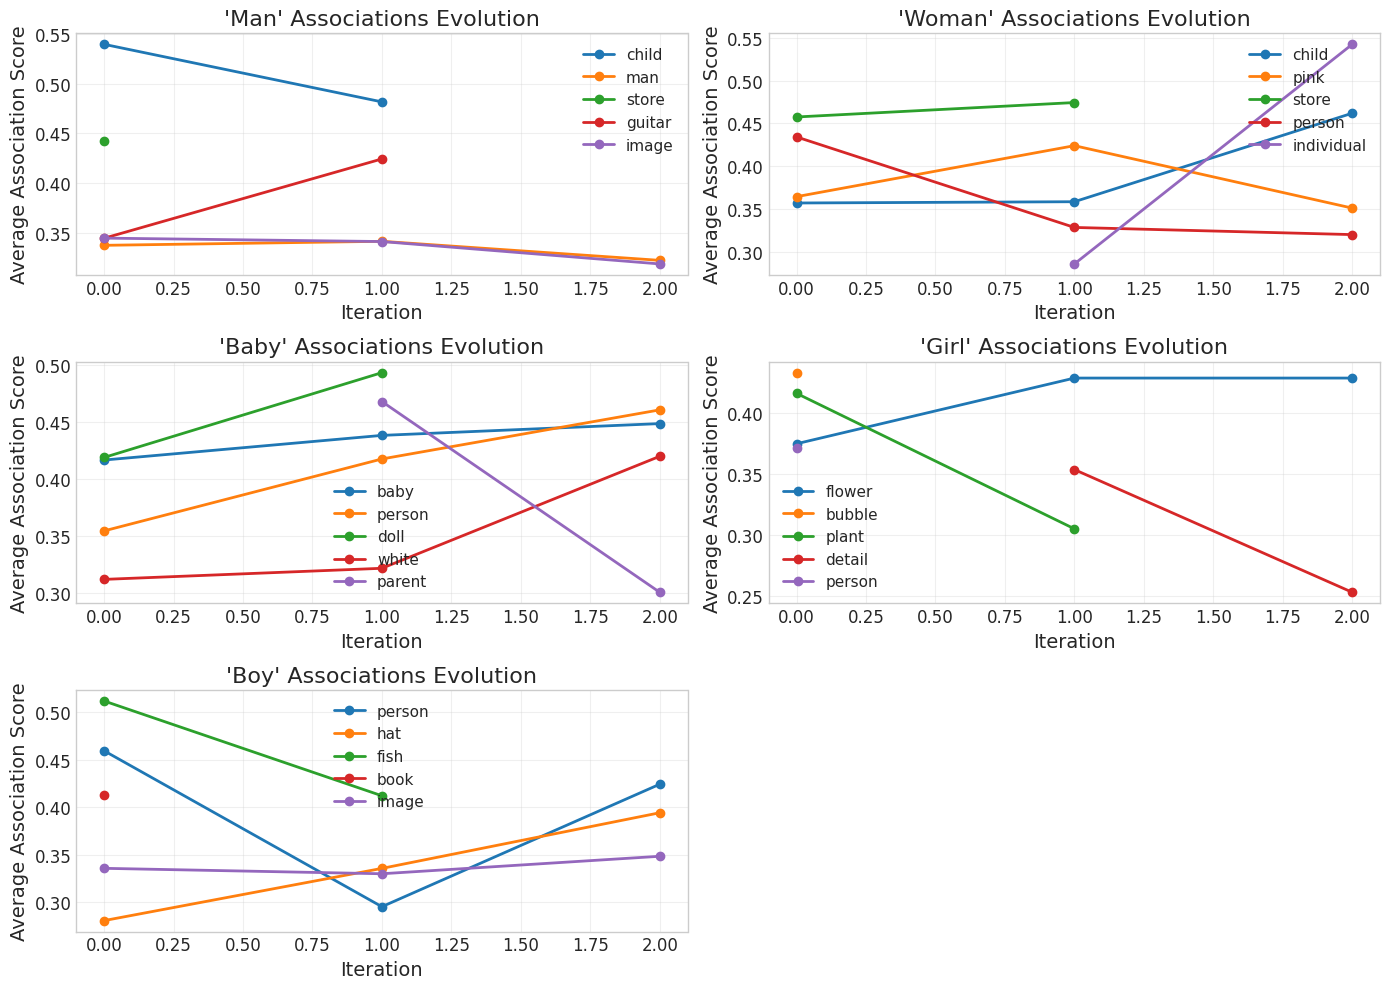

In [36]:
import json
import yaml
from collections import defaultdict
from biasana.association_analyzer import AssociationAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm  # Import tqdm for notebooks

# Initialize analyzer
analyzer = AssociationAnalyzer(min_df=1)
subgroups = ["man", "woman", "baby", "girl", "boy"]
top_n = 5  # Number of top terms to track

# Structure to store associations across iterations
association_history = {sub: defaultdict(dict) for sub in subgroups}

# Process each example's iterations with tqdm
for example in tqdm(data, desc="Processing Examples"):  # Wrap the outer loop with tqdm
    for iter_idx, text in enumerate(example['lineage']):
        # Analyze current iteration text
        results = analyzer.analyze_subgroup_terms([text.lower()], subgroups)

        # Record top associations for each subgroup
        for sub in subgroups:
            top_assoc = analyzer.get_top_associations(results, sub, n=top_n)
            for rank, (word, score) in enumerate(top_assoc):
                association_history[sub][word][iter_idx] = association_history[sub][word].get(iter_idx, []) + [score]

# Calculate average scores across examples per iteration
avg_scores = {sub: defaultdict(dict) for sub in subgroups}
for sub in subgroups:
    for word in association_history[sub]:
        for iter_idx in association_history[sub][word]:
            avg = np.mean(association_history[sub][word][iter_idx])
            avg_scores[sub][word][iter_idx] = avg

# Visualization
plt.figure(figsize=(14, 10))
colors = plt.cm.tab10.colors

for idx, sub in enumerate(subgroups):
    ax = plt.subplot(3, 2, idx + 1)

    # Get top terms across all iterations
    all_terms = []
    for iter_idx in sorted(set([k for word in avg_scores[sub] for k in avg_scores[sub][word]])):
        iter_terms = sorted(avg_scores[sub].items(),
                            key=lambda x: x[1].get(iter_idx, 0),
                            reverse=True)[:top_n]
        all_terms.extend([t[0] for t in iter_terms])

    # Select top 5 most frequent terms
    unique_terms = list(set(all_terms))
    term_counts = {t: all_terms.count(t) for t in unique_terms}
    top_terms = sorted(term_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_terms = [t[0] for t in top_terms]

    # Plot evolution for selected terms
    for term_idx, term in enumerate(top_terms):
        x = []
        y = []
        for iter_idx in sorted(avg_scores[sub][term].keys()):
            x.append(iter_idx)
            y.append(avg_scores[sub][term][iter_idx])

        ax.plot(x, y,
                marker='o',
                color=colors[term_idx],
                label=term,
                linewidth=2)

    ax.set_title(f"'{sub.title()}' Associations Evolution")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Average Association Score")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('association_evolution.png', dpi=300)
plt.show()

In [37]:
# Define the subgroups you want to track
subgroups = ["man", "woman", "baby", "girl", "boy"]

# Determine the maximum number of iterations across all examples (i.e. the maximum lineage length)
max_iter = max(len(example["lineage"]) for example in data)

# Dictionary to store association results per iteration
iteration_results = {}

# Loop over each iteration index
for i in range(max_iter):
    documents = []
    # Aggregate the caption at iteration i for each example (if it exists)
    for example in data:
        if i < len(example["lineage"]):
            documents.append(example["lineage"][i])
    
    if not documents:
        continue  # Skip if no documents for this iteration
    
    # Initialize the analyzer for this iteration (min_df=1 so every word is counted)
    analyzer = AssociationAnalyzer(min_df=1)
    
    # Perform association analysis on the aggregated documents
    results = analyzer.analyze_subgroup_terms(documents, subgroups)
    
    # Save the top associations for each subgroup (e.g., top 5)
    iteration_results[i] = {}
    for subgroup in subgroups:
        top_assoc = analyzer.get_top_associations(results, subgroup, n=5)
        iteration_results[i][subgroup] = top_assoc

# Now, print out the results for each iteration
for iter_idx, associations in iteration_results.items():
    print(f"\nIteration {iter_idx}:")
    for subgroup in subgroups:
        print(f"\nTop associations for '{subgroup}':")
        for word, score in associations[subgroup]:
            print(f" - {word}: {score:.4f}")


Iteration 0:

Top associations for 'man':
 - man: 0.2972
 - image: 0.1262
 - short: 0.1014
 - late: 0.0922
 - early: 0.0922

Top associations for 'woman':
 - woman: 0.2677
 - image: 0.1280
 - hair: 0.0849
 - portrait: 0.0780
 - style: 0.0776

Top associations for 'baby':
 - baby: 0.4596
 - image: 0.1321
 - close: 0.1066
 - onesie: 0.1025
 - blanket: 0.0840

Top associations for 'girl':
 - girl: 0.3451
 - image: 0.1248
 - young: 0.1118
 - smile: 0.0877
 - hair: 0.0823

Top associations for 'boy':
 - boy: 0.4145
 - image: 0.1197
 - young: 0.1127
 - shirt: 0.0995
 - short: 0.0908

Iteration 1:

Top associations for 'man':
 - man: 0.3893
 - image: 0.1053
 - dark: 0.0811
 - short: 0.0807
 - late: 0.0709

Top associations for 'woman':
 - woman: 0.3242
 - image: 0.1063
 - hair: 0.0588
 - slightly: 0.0534
 - smile: 0.0533

Top associations for 'baby':
 - baby: 0.4795
 - image: 0.1167
 - onesie: 0.1024
 - close: 0.0851
 - focus: 0.0736

Top associations for 'girl':
 - girl: 0.4166
 - young: 0.

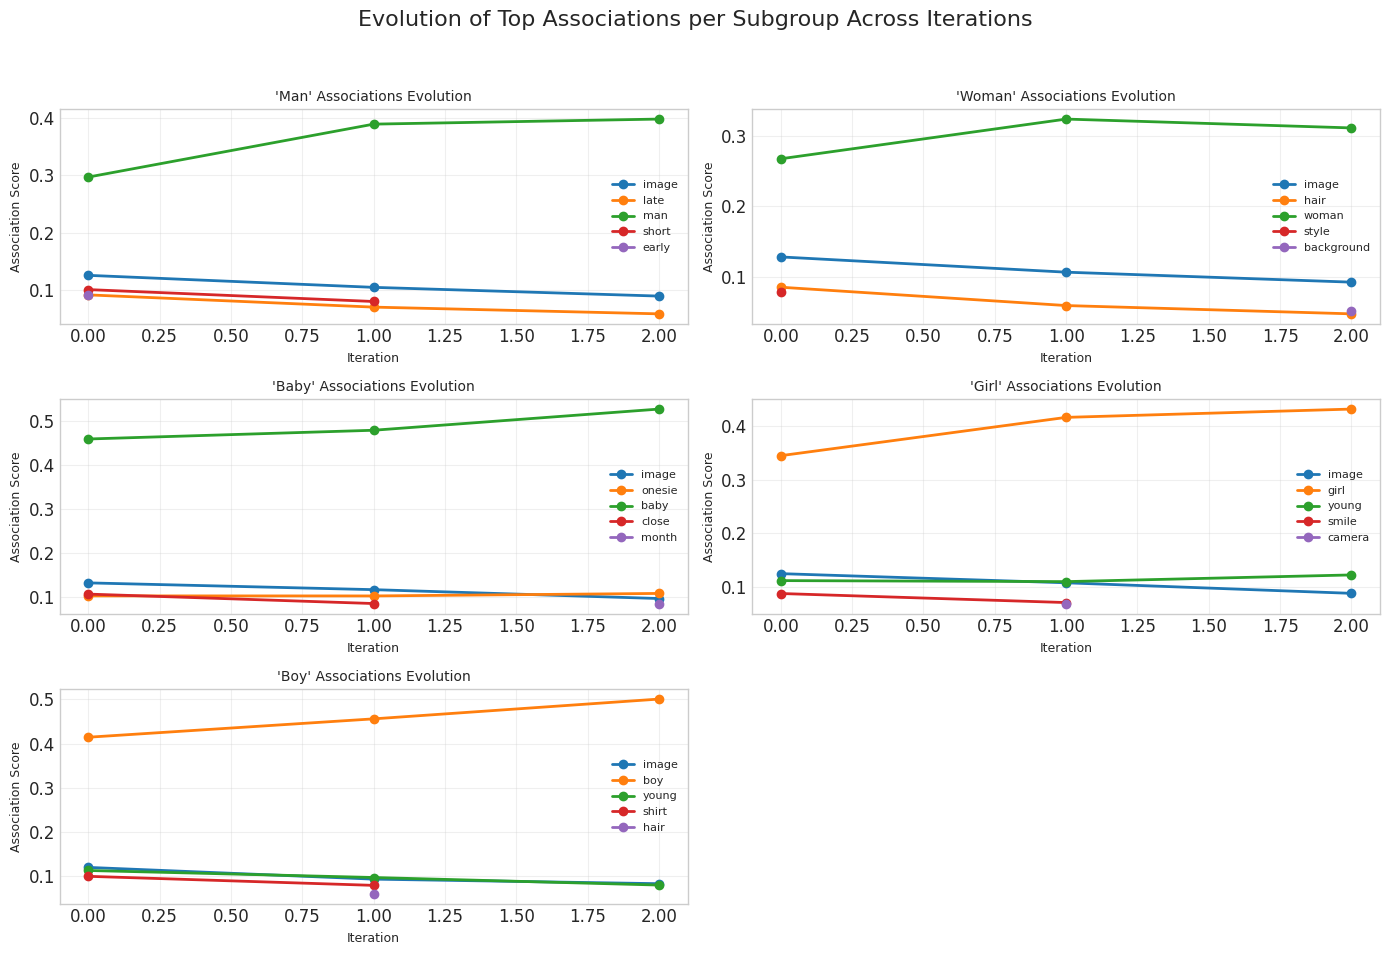

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Sample results from your output
results = {
    0: {
        "man": [("man", 0.2972), ("image", 0.1262), ("short", 0.1014), ("late", 0.0922), ("early", 0.0922)],
        "woman": [("woman", 0.2677), ("image", 0.1280), ("hair", 0.0849), ("portrait", 0.0780), ("style", 0.0776)],
        "baby": [("baby", 0.4596), ("image", 0.1321), ("close", 0.1066), ("onesie", 0.1025), ("blanket", 0.0840)],
        "girl": [("girl", 0.3451), ("image", 0.1248), ("young", 0.1118), ("smile", 0.0877), ("hair", 0.0823)],
        "boy": [("boy", 0.4145), ("image", 0.1197), ("young", 0.1127), ("shirt", 0.0995), ("short", 0.0908)]
    },
    1: {
        "man": [("man", 0.3893), ("image", 0.1053), ("dark", 0.0811), ("short", 0.0807), ("late", 0.0709)],
        "woman": [("woman", 0.3242), ("image", 0.1063), ("hair", 0.0588), ("slightly", 0.0534), ("smile", 0.0533)],
        "baby": [("baby", 0.4795), ("image", 0.1167), ("onesie", 0.1024), ("close", 0.0851), ("focus", 0.0736)],
        "girl": [("girl", 0.4166), ("young", 0.1099), ("image", 0.1077), ("smile", 0.0708), ("camera", 0.0684)],
        "boy": [("boy", 0.4561), ("young", 0.0968), ("image", 0.0931), ("shirt", 0.0790), ("hair", 0.0598)]
    },
    2: {
        "man": [("man", 0.3981), ("image", 0.0901), ("black", 0.0635), ("shirt", 0.0625), ("late", 0.0592)],
        "woman": [("woman", 0.3116), ("image", 0.0921), ("background", 0.0506), ("hair", 0.0470), ("white", 0.0441)],
        "baby": [("baby", 0.5277), ("onesie", 0.1081), ("image", 0.0965), ("month", 0.0844), ("old", 0.0668)],
        "girl": [("girl", 0.4321), ("young", 0.1224), ("image", 0.0880), ("background", 0.0625), ("cultural", 0.0622)],
        "boy": [("boy", 0.5009), ("historical", 0.0841), ("image", 0.0828), ("young", 0.0797), ("cultural", 0.0698)]
    }
}

subgroups = ["man", "woman", "baby", "girl", "boy"]
top_n = 5  # We'll consider top 5 terms

# Build data structure: avg_scores[subgroup][term][iteration] = score
avg_scores = {sub: {} for sub in subgroups}

for iter_idx, iter_data in results.items():
    for sub in subgroups:
        for term, score in iter_data[sub]:
            if term not in avg_scores[sub]:
                avg_scores[sub][term] = {}
            avg_scores[sub][term][iter_idx] = score

# Visualization: Plot evolution for each subgroup in a grid of subplots
plt.figure(figsize=(14, 10))
colors = plt.cm.tab10.colors

# We'll create a subplot for each subgroup (5 subgroups; using 3 rows x 2 columns)
n_rows, n_cols = 3, 2

for idx, sub in enumerate(subgroups):
    ax = plt.subplot(n_rows, n_cols, idx + 1)
    
    # Get top terms across all iterations for this subgroup:
    # Collect terms from each iteration
    all_terms = []
    iter_indices = set()
    for term in avg_scores[sub]:
        iter_indices.update(avg_scores[sub][term].keys())
    for iter_idx in sorted(iter_indices):
        iter_terms = sorted(avg_scores[sub].items(),
                            key=lambda x: x[1].get(iter_idx, 0),
                            reverse=True)[:top_n]
        all_terms.extend([t[0] for t in iter_terms])
    
    # Select the top 5 most frequent terms overall
    unique_terms = list(set(all_terms))
    term_counts = {t: all_terms.count(t) for t in unique_terms}
    top_terms = sorted(term_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_terms = [t[0] for t in top_terms]
    
    # Plot evolution for the selected terms
    for term_idx, term in enumerate(top_terms):
        x = []
        y = []
        for iter_idx in sorted(avg_scores[sub][term].keys()):
            x.append(iter_idx)
            y.append(avg_scores[sub][term][iter_idx])
        ax.plot(x, y,
                marker='o',
                color=colors[term_idx],
                label=term,
                linewidth=2)
    
    ax.set_title(f"'{sub.title()}' Associations Evolution", fontsize=10)
    ax.set_xlabel("Iteration", fontsize=9)
    ax.set_ylabel("Association Score", fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

# Remove extra subplot if any
if len(subgroups) < n_rows * n_cols:
    for extra in range(len(subgroups), n_rows * n_cols):
        plt.subplot(n_rows, n_cols, extra + 1).axis('off')

plt.suptitle("Evolution of Top Associations per Subgroup Across Iterations", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('association_evolution.png', dpi=300)
plt.show()


/tmp/ipykernel_115125/801951666.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20')  # You can change this to any colormap you prefer


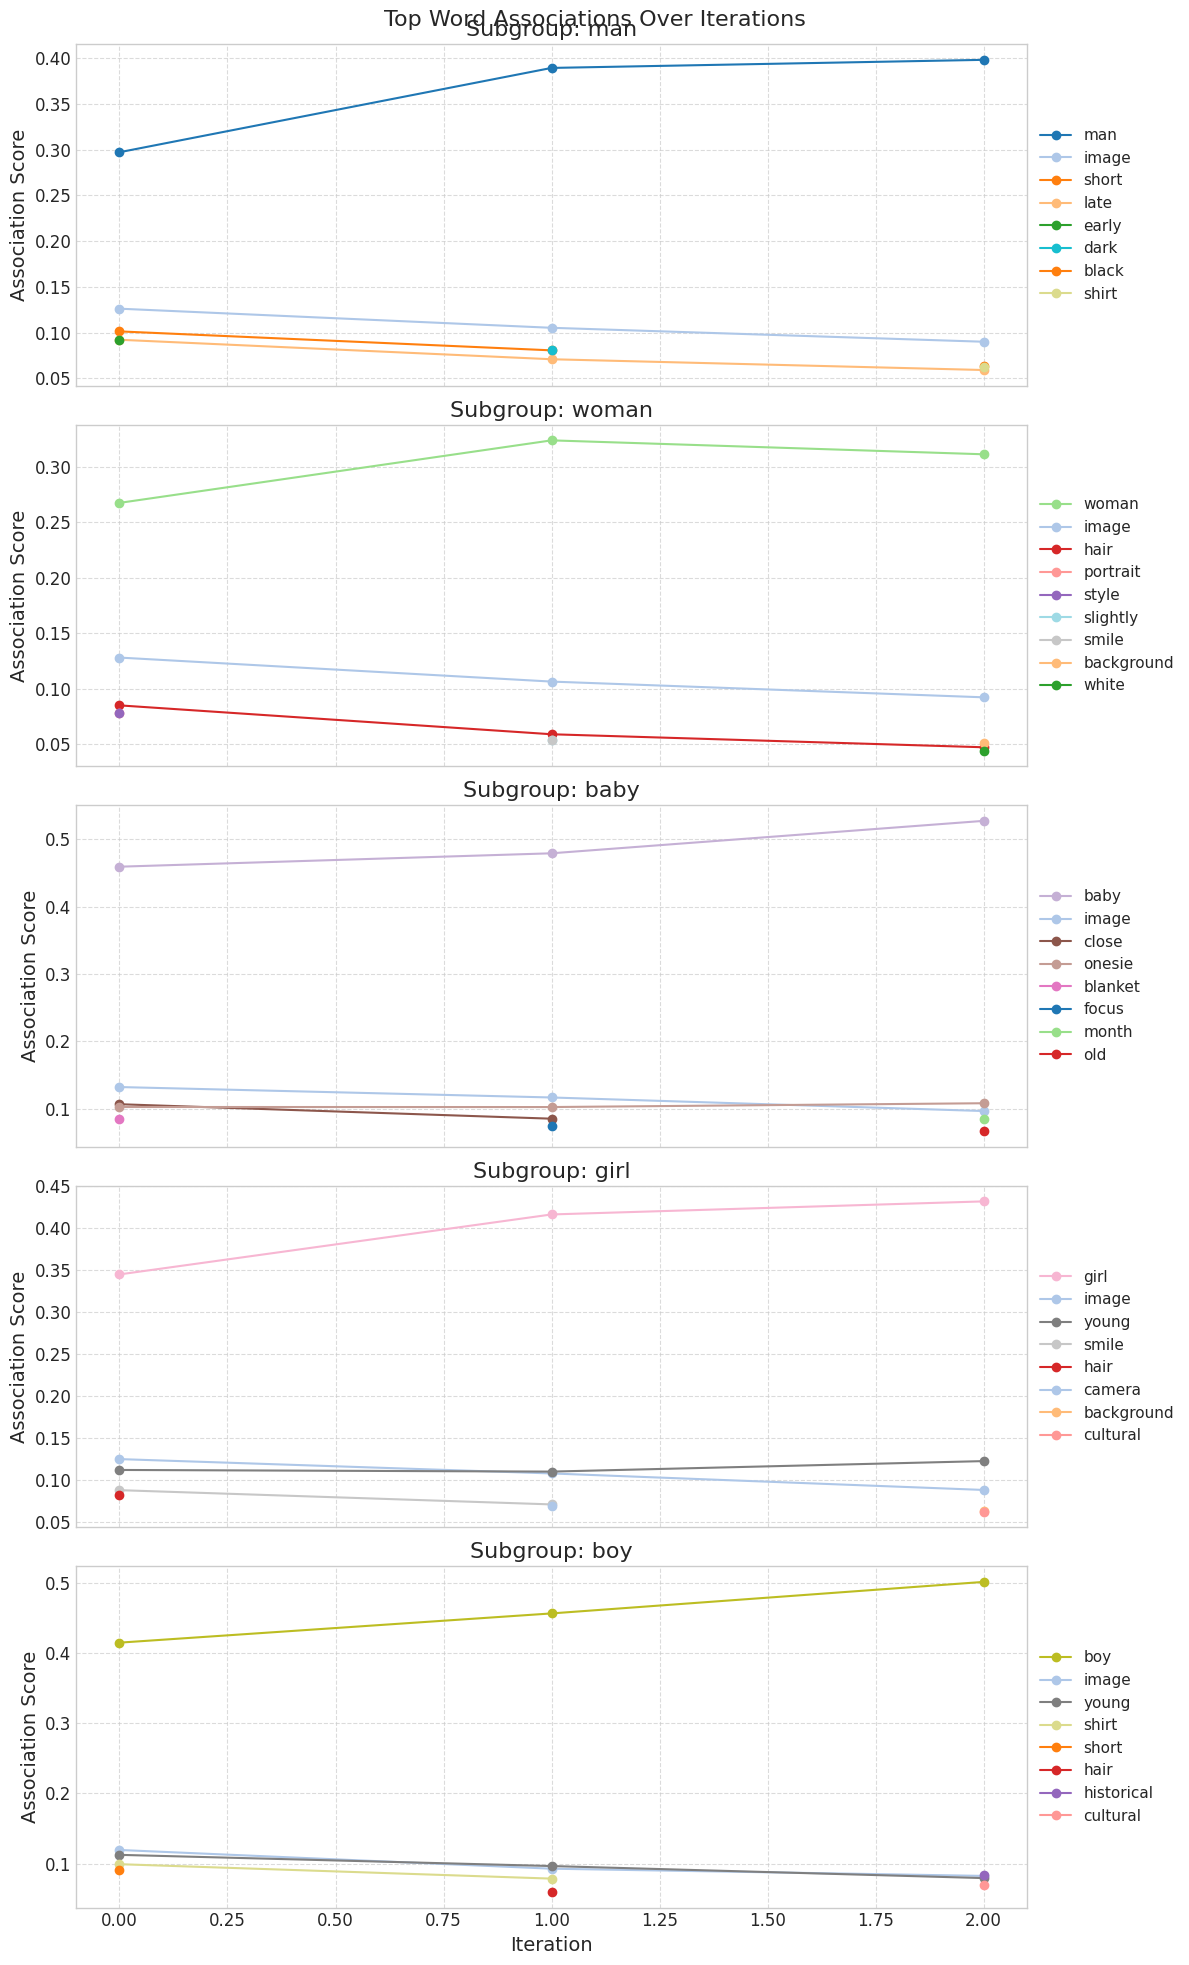

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming iteration_results is your dictionary of results

# Create a color map for words
word_colors = {}
color_index = 0
color_map = plt.cm.get_cmap('tab20')  # You can change this to any colormap you prefer

# Prepare data for plotting
plot_data = {subgroup: {} for subgroup in subgroups}

for iter_idx, associations in iteration_results.items():
    for subgroup in subgroups:
        for word, score in associations[subgroup]:
            if word not in word_colors:
                word_colors[word] = color_map(color_index % 20)
                color_index += 1
            
            if word not in plot_data[subgroup]:
                plot_data[subgroup][word] = [None] * len(iteration_results)
            plot_data[subgroup][word][iter_idx] = score

# Create subplots
fig, axs = plt.subplots(len(subgroups), 1, figsize=(12, 4*len(subgroups)), sharex=True)
fig.suptitle("Top Word Associations Over Iterations", fontsize=16)

for idx, subgroup in enumerate(subgroups):
    ax = axs[idx]
    ax.set_title(f"Subgroup: {subgroup}")
    ax.set_ylabel("Association Score")
    
    for word, scores in plot_data[subgroup].items():
        x = np.arange(len(iteration_results))
        y = scores
        ax.plot(x, y, 'o-', label=word, color=word_colors[word])
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, linestyle='--', alpha=0.7)

axs[-1].set_xlabel("Iteration")
plt.tight_layout()
plt.show()


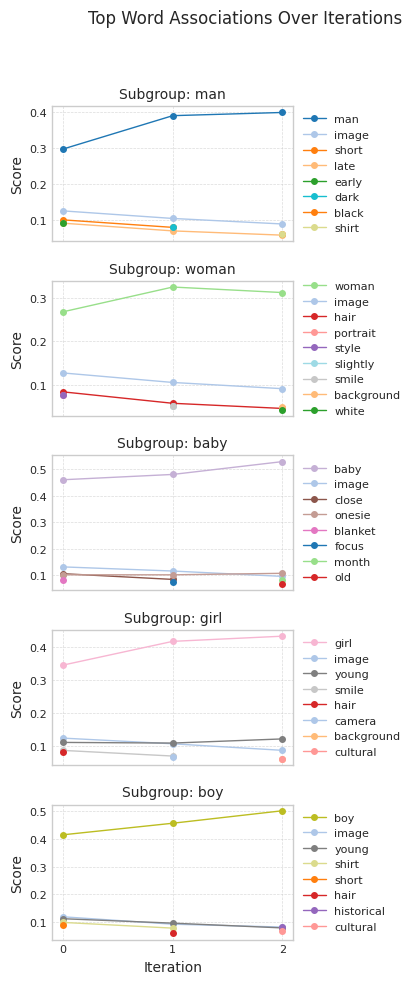

In [46]:
# Create subplots with adjusted figure size
fig, axs = plt.subplots(len(subgroups), 1, figsize=(5, 2*len(subgroups)), sharex=True)  # Reduced width and height
fig.suptitle("Top Word Associations Over Iterations", fontsize=12) #smaller title

for idx, subgroup in enumerate(subgroups):
    ax = axs[idx]
    ax.set_title(f"Subgroup: {subgroup}", fontsize=10) #smaller title
    ax.set_ylabel("Score", fontsize=10) #smaller label
    ax.tick_params(axis='both', which='major', labelsize=8) #smaller ticks

    for word, scores in plot_data[subgroup].items():
        x = np.arange(len(iteration_results))
        y = scores
        ax.plot(x, y, 'o-', label=word, color=word_colors[word], markersize=4, linewidth=1) #smaller markers and lines

    # More compact legend
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8, ncol=1)  # Smaller font, single column

    ax.set_xticks(np.arange(len(iteration_results))) # Ensure all x-axis ticks are shown
    ax.set_xticklabels(np.arange(len(iteration_results))) # Set x-axis labels to 0, 1, 2
    ax.grid(True, linestyle='--', alpha=0.7, linewidth=0.5) #thinner grid

axs[-1].set_xlabel("Iteration", fontsize=10) #smaller label

plt.tight_layout(rect=[0, 0, 0.85, 0.95]) # Adjust tight layout to accommodate legend
plt.show()


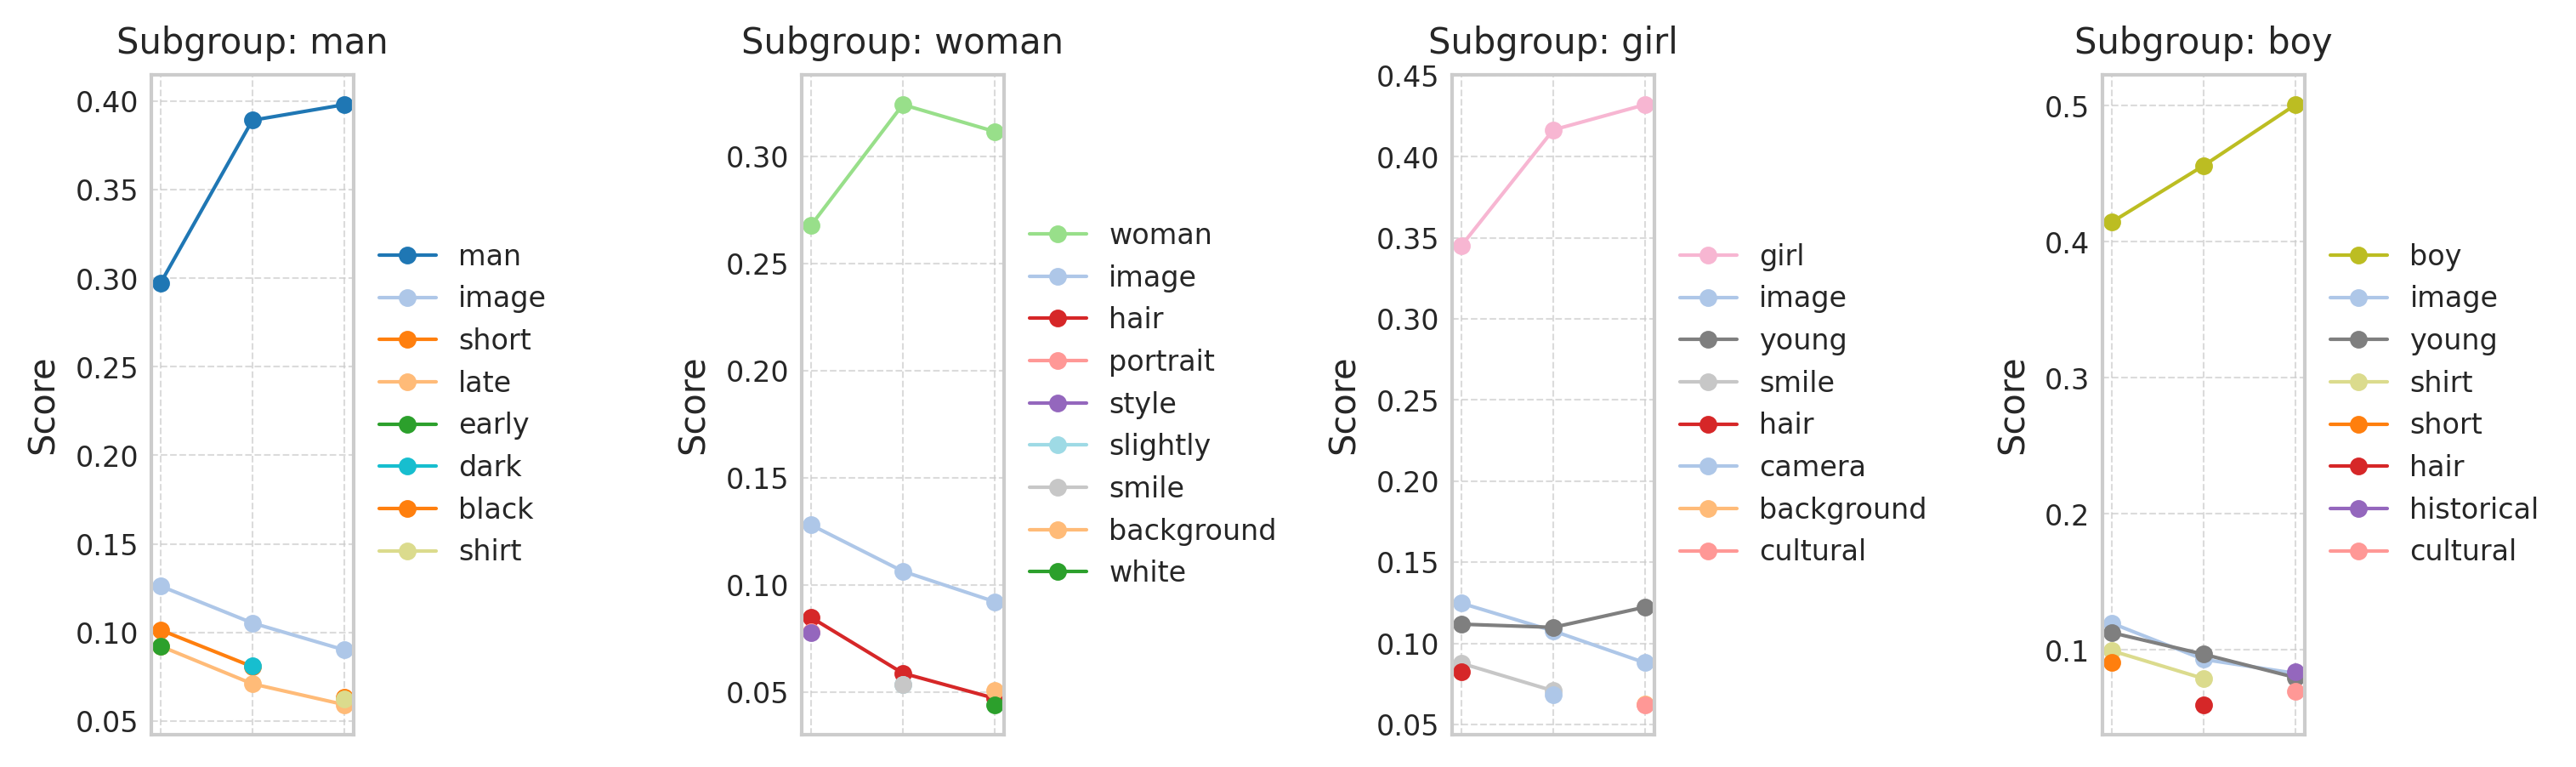

In [53]:
# Filter out "baby" from subgroups
filtered_subgroups = [subgroup for subgroup in subgroups if subgroup != "baby"]

# Determine the layout (4x4, but adjust as needed)
nrows = 4
ncols = 4
n_subplots = min(nrows * ncols, len(filtered_subgroups))  # Limit to available subgroups

# Create subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 12), sharex=True, dpi=300)  # Adjust figure size as needed
#fig.suptitle("Top Word Associations Over Iterations", fontsize=16)

# Flatten the axs array for easier indexing
axs = axs.flatten()

for idx, subgroup in enumerate(filtered_subgroups):
    if idx >= n_subplots:  # Stop if we've filled all subplots
        break

    ax = axs[idx]
    ax.set_title(f"Subgroup: {subgroup}", fontsize=10)
    ax.set_ylabel("Score", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

    for word, scores in plot_data[subgroup].items():
        x = np.arange(len(iteration_results))
        y = scores
        ax.plot(x, y, 'o-', label=word, color=word_colors[word], markersize=4, linewidth=1)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8, ncol=1)
    ax.set_xticks(np.arange(len(iteration_results)))
    ax.set_xticklabels(np.arange(len(iteration_results)))
    ax.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)

    if idx // ncols == nrows - 1:  # Only label the last row
        ax.set_xlabel("Iteration", fontsize=10)


# Hide any unused subplots
for i in range(len(filtered_subgroups), nrows * ncols):
    fig.delaxes(axs[i])

plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()

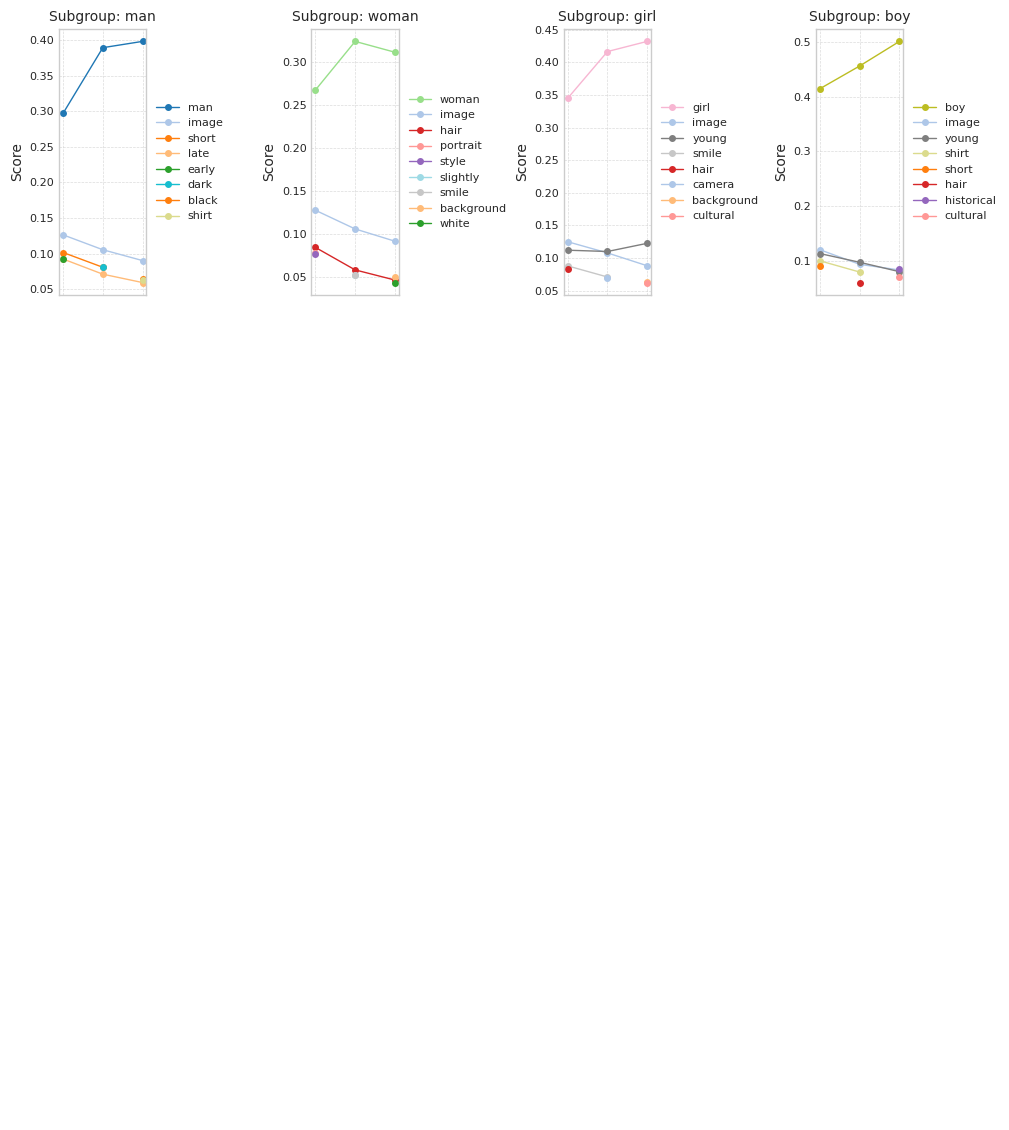

In [51]:
# Filter out "baby" from subgroups
filtered_subgroups = [subgroup for subgroup in subgroups if subgroup != "baby"]

# Determine the layout (4x4 or adjust as needed)
nrows = 4
ncols = 4
n_subplots = min(nrows * ncols, len(filtered_subgroups))  # Limit to available subgroups

# Create subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 12), sharex=True)  # Adjust figsize as needed
#fig.suptitle("Top Word Associations Over Iterations", fontsize=16)

# Flatten the axs array for easier indexing
axs = axs.flatten()

for idx, subgroup in enumerate(filtered_subgroups):
    if idx >= n_subplots: #stop when you have enough plots
        break
    ax = axs[idx]
    ax.set_title(f"Subgroup: {subgroup}", fontsize=10)
    ax.set_ylabel("Score", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

    for word, scores in plot_data[subgroup].items():
        x = np.arange(len(iteration_results))
        y = scores
        ax.plot(x, y, 'o-', label=word, color=word_colors[word], markersize=4, linewidth=1)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8, ncol=1)
    ax.set_xticks(np.arange(len(iteration_results)))
    ax.set_xticklabels(np.arange(len(iteration_results)))
    ax.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)

    if idx // ncols == nrows - 1: # only label the last row
        ax.set_xlabel("Iteration", fontsize=10)


# Hide any unused subplots
for j in range(idx + 1, nrows * ncols):
    axs[j].set_axis_off()

plt.tight_layout(rect=[0, 0, 0.85, 0.95], h_pad=0.5, w_pad=0.3)  # Adjust padding as needed
plt.show()
